# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые перешли на новые тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных уже сделана.

Необходимо построить модель с максимально большим значением *accuracy* и довести долю правильных ответов по крайней мере до 0.75. Проверить *accuracy* на тестовой выборке.

## Откройте и изучите файл

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
import joblib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
#import seaborn as sns

data = pd.read_csv('/datasets/users_behavior.csv')
data.info()
display(data.head())
display(data.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


,calls,minutes,messages,mb_used,is_ultra
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0
3213,80.0,566.09,6.0,29480.52,1


Файл содержит 3214 записей (объектов) о потреблении услуг связи пользователей моьбильной связи. Предобработка данных была сделана ранее.

Проверим данные в выборке на мультиколлениарность. Для определения связей построим матрицу парных коэффициентов корреляции для выборки и также посмотрим зависимости на графике. 

In [2]:
display(data.corr())

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


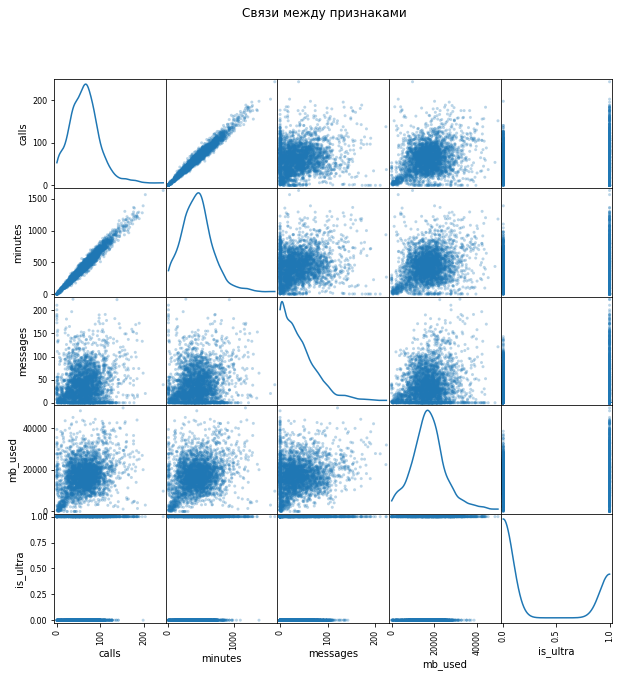

In [3]:
scatter_matrix(data, alpha=0.3, figsize=(10, 10), diagonal='kde')
plt.suptitle('Связи между признаками')
plt.show()

Наблюдается сильная связь между признаками 'calls' и 'minutes', корреляция близка к единице. На графике также видно, что эта связь имеет линейный характер. Факторы модели явно коллениарны, если они находятся между собой в линейной завимирсти и коэффициент корреляции >0.7, т.е. это наш случай. Так как факторы 'calls' и 'minutes' фактически дублируют друг друга, один из них необходимо исключить. Исключим фактор 'calls', т.к. он имеет немного более сильные связи с другими параметрами, чем 'minutes'.

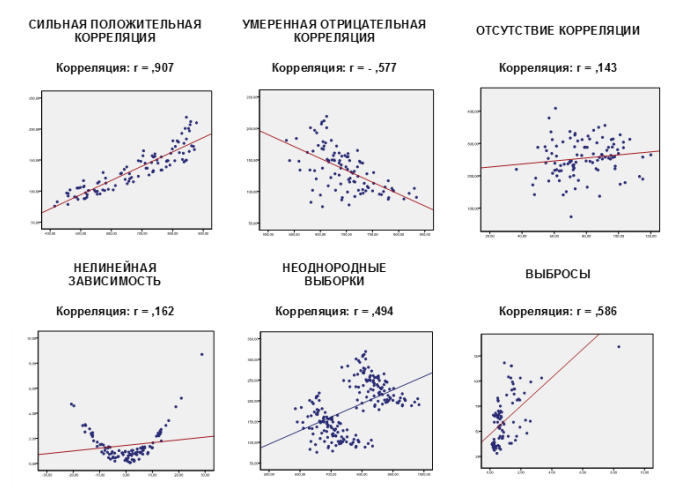

In [4]:
data.drop('calls', axis=1, inplace=True)
display(data.head())

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


## Разбейте данные на выборки

Данные разобъем на три части: обучающую, валидационную и тестовую. Размеры
тестового и валидационного наборов сделаем равными. Исходные данные разобъем в соотношении 3:1:1.

Выделим тестовые данные *data_test*

In [5]:
data_train_valid, data_test = train_test_split(
                        data, test_size=0.2, random_state=12345)

In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643 entries, 1415 to 1196
Data columns (total 4 columns):
minutes     643 non-null float64
messages    643 non-null float64
mb_used     643 non-null float64
is_ultra    643 non-null int64
dtypes: float64(3), int64(1)
memory usage: 25.1 KB


Выделим данные для обучения и валидации *data_train* и *data_valid*

In [7]:
data_train, data_valid = train_test_split(
                        data_train_valid, test_size=0.25, random_state=12345)

In [8]:
data_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643 entries, 2699 to 1806
Data columns (total 4 columns):
minutes     643 non-null float64
messages    643 non-null float64
mb_used     643 non-null float64
is_ultra    643 non-null int64
dtypes: float64(3), int64(1)
memory usage: 25.1 KB


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 2656 to 510
Data columns (total 4 columns):
minutes     1928 non-null float64
messages    1928 non-null float64
mb_used     1928 non-null float64
is_ultra    1928 non-null int64
dtypes: float64(3), int64(1)
memory usage: 75.3 KB


Данные разбили на обучающие, валидационные и тестовые в соотношении 3:1:1.

In [10]:
print('Размер обучающей выборки:', data_train.shape)
print('Размер валидационной выборки:',data_valid.shape)
print('Размер тестовой выборки:',data_test.shape)

Размер обучающей выборки: (1928, 4)
Размер валидационной выборки: (643, 4)
Размер тестовой выборки: (643, 4)


## Исследуйте модели

Подготовим данные для обучения и валидации. Разделим данные на признаки и целевой признак - столбец *'is_ultra'*

In [11]:
features_train = data_train.drop(['is_ultra'], axis=1)
target_train = data_train['is_ultra']

features_valid = data_valid.drop(['is_ultra'], axis=1) 
target_valid = data_valid['is_ultra'] 

In [12]:
display(features_train.head())
display(target_train.head())
display(features_valid.head())
display(target_valid.head())

,minutes,messages,mb_used
2656,185.07,34.0,17166.53
823,290.69,77.0,21507.03
2566,289.83,15.0,22151.73
1451,333.49,50.0,17275.47
2953,300.39,69.0,17277.83


2656    0
823     0
2566    0
1451    0
2953    0
Name: is_ultra, dtype: int64

,minutes,messages,mb_used
2699,512.53,27.0,15772.68
242,1247.04,150.0,29186.41
2854,246.06,31.0,8448.76
1638,468.66,0.0,11794.34
1632,19.85,28.0,13107.42


2699    0
242     1
2854    0
1638    0
1632    0
Name: is_ultra, dtype: int64

### Решающее дерево

Для определения лучшей модели "Решающее дерево" рассмотрим результаты работы модели при изменении гиперпараметра - глубина дерева. Проверим для значений глубины от 1 до 10

In [13]:
best_model_tree = None
best_depth = 0
result = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    new_result = accuracy_score(target_valid, predictions_valid)
    if new_result > result:
        best_model_tree = model
        result = new_result
        best_depth = depth
    
print('Максимальная глубина:', best_depth)
print('Accuracy наилучшей модели на валидационной выборке:', result)

Максимальная глубина: 7
Accuracy наилучшей модели на валидационной выборке: 0.7682737169517885


Сохранаяем лучшую модель "Решающее дерево"

In [14]:
joblib.dump(best_model_tree, 'best_model_tree.joblib')

['best_model_tree.joblib']

### Случайный лес

Для определения лучшей модели с помощью алгоритма "Случайный  лес", рассмотрим результаты работы модели при изменении 2-х гиперпараметров - количество деревьев и глубина дерева. Проверим для значений: количество деревьев от 5 до 40 с шагом 5, глубина дерева от 1 до 20.

In [15]:
best_model_forest = None
best_result_forest = 0
best_est = 0
best_depth = 0

for est in range(5, 41, 5):
    for depth in range (1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        
        if result > best_result_forest:
            best_model_forest = model
            best_result_forest = result
            best_est = est
            best_depth = depth

print("Accuracy наилучшей модели на валидационной выборке:", best_result_forest)
print("Количество деревьев:", best_est)
print("Максимальная глубина:", best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.8055987558320373
Количество деревьев: 15
Максимальная глубина: 16


Сохранаяем полученную лучшую модель "Случайный лес"

In [16]:
joblib.dump(best_model_forest, 'best_model_forest.joblib')

['best_model_forest.joblib']

### Логистическая регрессия

Обучим и проверим результат для модели логистической регрессии

In [17]:
model_logistic = LogisticRegression(random_state=12345, solver='lbfgs')
model_logistic.fit(features_train, target_train)
predictions_valid = model_logistic.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
result

0.7262830482115086

Сохранаяем модель "Логистическая регрессия"

In [18]:
joblib.dump(model_logistic, 'model_logistic.joblib')

['model_logistic.joblib']

Обучены и отобраны лучшие модели для трех алгоритмов: Решающее дерево, Случайный лес, Логистическая регрессия.

## Проверьте модель на тестовой выборке

Подготовим данные для тестирования.

In [19]:
features_test = data_test.drop(['is_ultra'], axis=1)
target_test = data_test['is_ultra']

Выполняем тестирование обученных моделей на тестовой выборке.

In [20]:
models_dict = {'Решающее дерево':'best_model_tree.joblib',
               'Случайный лес':'best_model_forest.joblib',
               'Логистическая регрессия':'model_logistic.joblib'}

for key in models_dict:
    model = joblib.load(models_dict[key])
    predictions_test = model.predict(features_test)
    result = accuracy_score(target_test, predictions_test)
    print('Accuracy модели ' + key + ' на тестовой выборке:', result)

Accuracy модели Решающее дерево на тестовой выборке: 0.7713841368584758
Accuracy модели Случайный лес на тестовой выборке: 0.7884914463452566
Accuracy модели Логистическая регрессия на тестовой выборке: 0.7589424572317263


Все три модели обеспечили необходимую точность (>=0.75). Точность результатов сопоставима на валидационной и тестовой выборках. Наилучший результат на тестовой выборке показал алгоритм классификации Случайный лес - 0.788. При этом данный алгоритм требует больше всех времени. Самый быстрый, но и имеющий точность ниже остальных - Логистическая регрессия.

Объединенная выборка трейн+валид была отобрана ранее

In [21]:
data_train_valid.shape

(2571, 4)

Подготовим данные

In [22]:
features_train_valid = data_train.drop(['is_ultra'], axis=1)
target_train_valid = data_train['is_ultra']

Обучим на объединенной выборке с подобранными параметрами и проверим на тестовой модель Решающее дерево

In [23]:
model_new = DecisionTreeClassifier(random_state=12345, max_depth=7)
model_new.fit(features_train_valid, target_train_valid)
predictions_test = model_new.predict(features_test)
result = accuracy_score(target_test, predictions_test)

print('Accuracy новой модели Решающее дерево на тестовой выборке:', result)

Accuracy новой модели Решающее дерево на тестовой выборке: 0.7713841368584758


Проделаем это же для модели Случайный лес.

In [24]:
model_new = RandomForestClassifier(random_state=12345, n_estimators=15, max_depth=16)
model_new.fit(features_train_valid, target_train_valid)
predictions_test = model_new.predict(features_test)
result = accuracy_score(target_test, predictions_test)

print('Accuracy новой модели Случайный лес на тестовой выборке:', result)

Accuracy новой модели Случайный лес на тестовой выборке: 0.7884914463452566


И для модели Логистическая регрессия

In [25]:
model_new = LogisticRegression(random_state=12345, solver='lbfgs')
model_new.fit(features_train_valid, target_train_valid)
predictions_test = model_new.predict(features_test)
result = accuracy_score(target_test, predictions_test)

print('Accuracy новой модели Логистическая регрессия на тестовой выборке:', result)

Accuracy новой модели Логистическая регрессия на тестовой выборке: 0.7589424572317263


## (бонус) Проверьте модели на адекватность

Для проверки моделей на адекватность сравним их качество с константной моделью. Для начала определим константу - наиболее распространенный класс в target_train.

Если качество твоей модели окажется ниже, чем качество константной модели, значит твоя модель бесполезна.

In [26]:
data_train['is_ultra'].value_counts()

0    1339
1     589
Name: is_ultra, dtype: int64

Константа - 0. Создадим константный столбец, такой же длины как столбец таргетов на тесте и измерим качество предсказаний той же метрикой, какой тестировали качество моделей.

In [27]:
target_const_model = pd.Series(0, index=target_test.index)
target_const_model

1415    0
916     0
1670    0
686     0
2951    0
       ..
2061    0
1510    0
2215    0
664     0
1196    0
Length: 643, dtype: int64

In [28]:
for key in models_dict:
    model = joblib.load(models_dict[key])
    predictions_test = model.predict(features_test)
    result = accuracy_score(target_const_model, predictions_test)
    print('Accuracy константной модели для алгоритма ' + key + ':', result)

Accuracy константной модели для алгоритма Решающее дерево: 0.833592534992224
Accuracy константной модели для алгоритма Случайный лес: 0.7729393468118196
Accuracy константной модели для алгоритма Логистическая регрессия: 0.9175738724727839


Качество моделей Решающее дерево и Логистическая регрессия ниже, чем качество константной модели. Отбрасываем эти модели. Принимаем модель с алгоритмом Случайный лес. Точность лучшей модели на тестовой выборке 0.788 - accuracy превышает необходимый минимум. 

In [29]:
strategies = ['most_frequent']

dummy_results = []
for strategy in strategies:
    dc = DummyClassifier(strategy = strategy, random_state = 1234)

    dc.fit(features_train_valid, target_train_valid)
    result = dc.score(features_test, target_test)
    dummy_results.append({strategy: result})
pd.DataFrame(dummy_results)

,most_frequent
0,0.695179
